In [1]:
import numpy as np
import pandas as pd
import random as r
import math
import os
from datetime import timedelta

import matplotlib.pyplot as plot
import networkx as nx
import seaborn as sns

from pyomo.environ import *
from pyomo.opt import SolverFactory
from gurobipy import GRB

In [2]:
#id directories
data_dir = os.getcwd().replace('/model', '/data')
results_dir = os.getcwd().replace('/model', '/results')

In [3]:
CAP_reliability = 0 # -1 if 1 sd below mean, -2 if 2 sd below mean
DEMAND_reliability = 0 #1 if 1 sd above mean, 2 if 2 sd above mean

budget_level = 8
warehouse_cap_level = 3 #time intervals of supply that can be stored

In [4]:
#define sets
K = 1
I = 4
T = 10

In [5]:
#define parameters

#rank
r_k_dict = {
    1 : 1
}

#quality (supplier 4 has the highest quality)
q_k_i_dict = {
    tuple([1,1]) : 2,
    tuple([1,2]): 2,
    tuple([1,3]): 2,
    tuple([1,4]): 3
}

#starting inventory
z_k_i_init_dict = {
    tuple([1,1]) : 12000/4,
    tuple([1,2]) : 12000/4,
    tuple([1,3]) : 12000/4,
    tuple([1,4]) : 12000/4
}

alpha_k_init_dict = {
    1 : 1000
}

#lead time (supplier 3 has the lowest lead time)
f_k_i_tDiff_dict = {}

for k in range(1,K+1):
    for i in range(1,I+1):
        for t in range(T+1):
            if (i == 3):
                if (t == 0):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                elif (t == 1):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                elif (t == 2):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                elif (t == 3):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                else:
                    f_k_i_tDiff_dict[tuple([k,i,t])] = 0
            else:
                if (t == 3):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                elif (t == 4):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                elif (t == 5):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                elif (t == 6):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                else:
                    f_k_i_tDiff_dict[tuple([k,i,t])] = 0
                    

o_k_i_t_dict = {}

for k in range(1,K+1):
    for i in range(1,I+1):
        for t in range(1,T+1):
            if t < 3:
                o_k_i_t_dict[tuple([k,i,t])] = 1000
            else:
                o_k_i_t_dict[tuple([k,i,t])] = 0
                    
#size
s_k_dict = {
    1 : .5
}

#warehouse capacity
h = 11918*.5*warehouse_cap_level #assuming warehouse capacity is not an issue

#cost (supplier 2 has the lowest cost)
c_k_i_dict = {
    tuple([1,1]) : 1,
    tuple([1,2]) : .8,
    tuple([1,3]) : 1,
    tuple([1,4]) : 1
}

b = 12000*budget_level

#lead time (supplier 1 has the higest capacity)
CAP_k_i_t_dict_mu_sd = {}

for k in range(1,K+1):
    for i in range(1,I+1):
        for t in range(T+1):
            if (i == 1):
                CAP_k_i_t_dict_mu_sd[tuple([k,i,t])] = [30000, 30000*.25]
            else:
                CAP_k_i_t_dict_mu_sd[tuple([k,i,t])] = [10000, 10000*.25]

#constant
D_k_t_dict_mu_sd = {
    tuple([1,1]) : [12000, 12000*.25],
    tuple([1,2]) : [12000, 12000*.25],
    tuple([1,3]) : [12000, 12000*.25],
    tuple([1,4]) : [12000, 12000*.25],
    tuple([1,5]) : [12000, 12000*.25],
    tuple([1,6]) : [12000, 12000*.25],
    tuple([1,7]) : [12000, 12000*.25],
    tuple([1,8]) : [12000, 12000*.25],
    tuple([1,9]) : [12000, 12000*.25],
    tuple([1,10]) : [12000, 12000*.25]
}

#surge (late)
#D_k_t_dict_mu_sd = {
#    tuple([1,1]) : [5000, 12000*.25],
#    tuple([1,2]) : [5000, 12000*.25],
#    tuple([1,3]) : [5000, 12000*.25],
#    tuple([1,4]) : [10000, 12000*.25],
#    tuple([1,5]) : [15000, 12000*.25],
#    tuple([1,6]) : [20000, 12000*.25],
#    tuple([1,7]) : [20000, 12000*.25],
#    tuple([1,8]) : [20000, 12000*.25],
#    tuple([1,9]) : [15000, 12000*.25],
#    tuple([1,10]) : [5000, 12000*.25]
#}

#surge (early)
#D_k_t_dict_mu_sd = {
#    tuple([1,1]) : [10000, 12000*.25],
#    tuple([1,2]) : [15000, 12000*.25],
#    tuple([1,3]) : [20000, 12000*.25],
#    tuple([1,4]) : [20000, 12000*.25],
#    tuple([1,5]) : [20000, 12000*.25],
#    tuple([1,6]) : [15000, 12000*.25],
#    tuple([1,7]) : [5000, 12000*.25],
#    tuple([1,8]) : [5000, 12000*.25],
#    tuple([1,9]) : [5000, 12000*.25],
#    tuple([1,10]) : [5000, 12000*.25],
#}

In [6]:
#data checks

mu = 0

for k in range(K):
    for t in range(T):
        mu = D_k_t_dict_mu_sd.get(tuple([k+1,t+1]))[0] + mu


check = np.zeros(I)

for k in range(1,K+1):
    for i in range(1,I+1):
        for t in range(T+1):
            check[i-1] = f_k_i_tDiff_dict.get(tuple([k,i,t])) + check[i-1]

In [7]:

model = ConcreteModel()

#####define sets#######
model.K = Set(initialize = range(1,K+1))
model.I = Set(initialize = range(1,I+1))
model.T = Set(initialize = range(1,T+1))

####initialize parameters####

def rank_param_initialize(model, k):
    return(r_k_dict.get(k))

model.r_k = Param(model.K, initialize = rank_param_initialize)

#model.r_k.pprint()

def penalty_param_initialize(model, k):
    return(1/model.r_k[k])

model.p_k = Param(model.K, initialize = penalty_param_initialize)

#model.p_k.pprint()

def discount_param_initialize(model, k, t):
    discount_temp = model.p_k[k]
    #time_diff = T-t
    return(1/((1+discount_temp)**(t-1)))

model.tau_k_t = Param(model.K, model.T, initialize = discount_param_initialize)

#model.tau_k_t.pprint()

def quality_param_initialize(model, k, i):
    return(q_k_i_dict.get(tuple([k,i])))

model.q_k_i = Param(model.K, model.I, initialize = quality_param_initialize)

#model.q_k_i.pprint()

def beg_inv_param_initialize(model, k, i):
    return(z_k_i_init_dict.get(tuple([k,i])))

model.z_k_i_init = Param(model.K, model.I, initialize = beg_inv_param_initialize)

#model.z_k_i_init.pprint()

def unfulfilled_demand_param_initialize(model, k):
    return(alpha_k_init_dict.get(k))

model.alpha_k_intialize = Param(model.K, initialize = unfulfilled_demand_param_initialize)

model.alpha_k_intialize.pprint()

def delay_dist_param_initialize(model, k, i, t):
    return(f_k_i_tDiff_dict.get(tuple([k,i,t])))

model.f_k_i_tDiff = Param(model.K, model.I, model.T, initialize = delay_dist_param_initialize)

#model.f_k_i_tDiff.pprint()

def incoming_orders_initialize(model, k, i, t):
    return(o_k_i_t_dict.get(tuple([k,i,t])))

model.o_k_i_t = Param(model.K, model.I, model.T, initialize = incoming_orders_initialize)

#model.o_k_i_t.pprint()

def item_size_param_initialize(model, k):
    return(s_k_dict.get(k))

model.s_k = Param(model.K, initialize = item_size_param_initialize)

#model.s_k.pprint()

def warehouse_cap_param_initialize(model):
    return(h)

model.h = Param(initialize = h)

#model.h.pprint()

def cost_param_initialize(model, k, i):
    return(c_k_i_dict.get(tuple([k,i])))

model.c_k_i = Param(model.K, model.I, initialize = cost_param_initialize)

#model.c_k_i.pprint()

def budget_param_initialize(model):
    return(b)

model.b = Param(initialize = budget_param_initialize)

#model.b.pprint()

def supplier_cap_param_initialize(model, k, i, t):
    temp = CAP_k_i_t_dict_mu_sd.get(tuple([k,i,t]))
    mean = temp[0]
    sd = CAP_reliability*temp[1]
    return(mean+sd)

model.cap_k_i_t = Param(model.K, model.I, model.T, initialize = supplier_cap_param_initialize)

#model.cap_k_i_t.pprint()

#assume preparing for one sd above the mean
def mu_plus_sigma_demand_param_initialize(model, k, t):
    temp = D_k_t_dict_mu_sd.get(tuple([k,t]))
    mean = temp[0]
    sd = DEMAND_reliability*temp[1]
    return(mean+sd)

model.d_k_t = Param(model.K, model.T, initialize = mu_plus_sigma_demand_param_initialize)

#model.d_k_t.pprint()

####initialize variables####
model.x_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount ordered
model.y_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount recieved
model.z_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)
model.alpha_k_t = Var(model.K, model.T, within = NonNegativeReals)
model.beta_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)

alpha_k_intialize : Size=1, Index=K, Domain=Any, Default=None, Mutable=False
    Key : Value
      1 :  1000


In [8]:
#def initialize_objective(model):
model.Objective = Objective(expr = 
                            (sum(model.q_k_i[k,i]*sum(model.tau_k_t[k,t]*model.beta_k_i_t[k,i,t] 
                                                      for t in model.T) 
                                 for i in model.I for k in model.K)),
                            sense = maximize)

In [9]:
def beggining_inventory_constraint_initialize(model, k, i):
    return(model.z_k_i_t[k,i,1] == model.z_k_i_init[k,i])
    
model.beggining_inventory_constraint = Constraint(model.K, model.I, 
                                                  rule = beggining_inventory_constraint_initialize)

In [10]:
def initalize_unsatisfied_demand_constraint_initialize(model, k):
    return(model.alpha_k_t[k,1] == model.alpha_k_intialize[k])

model.initalize_unsatisfied_demand_constraint_initialize = \
Constraint(model.K, rule = initalize_unsatisfied_demand_constraint_initialize)

In [11]:
def incoming_orders_constraint_initialize(model, k, i, t):
    return(model.y_k_i_t[k,i,t] - 
           sum(model.f_k_i_tDiff[k, i, t-t_ordered_time]*model.x_k_i_t[k,i,t_ordered_time] 
               for t_ordered_time in range(1,t)) - model.o_k_i_t[k,i,t] == 0)

model.incoming_ordered_constraint = Constraint(model.K, model.I, model.T, 
                                               rule = incoming_orders_constraint_initialize)

In [12]:
def calculate_available_inventory_constraint_initialize(model, k, i, t):
    if (t > 1):
        return(model.z_k_i_t[k,i,t] - model.z_k_i_t[k,i,t-1] - model.y_k_i_t[k,i,t-1] + model.beta_k_i_t[k,i,t-1] == 0)
    else:
        return(Constraint.Skip)
    
model.calculate_available_inventory_constraint = Constraint(model.K, model.I, model.T,
                                                            rule = 
                                                            calculate_available_inventory_constraint_initialize)

In [13]:
def cannot_fulfill_more_than_available_constraint_initialize(model, k,i,t):
    return(model.beta_k_i_t[k,i,t] - model.z_k_i_t[k,i,t] <= 0)

model.cannot_fulfill_more_than_available_constraint = \
Constraint(model.K, model.I, model.T, rule = cannot_fulfill_more_than_available_constraint_initialize)

In [14]:
def calculate_unsatisfied_demand_constraint_initialize(model,k,t):
    if t > 1:
        return(model.alpha_k_t[k,t] - model.alpha_k_t[k,t-1] + sum(model.beta_k_i_t[k,i,t] for i in model.I) == \
               model.d_k_t[k,t])
    else:
        return(Constraint.Skip)

model.calculate_unsatisfied_demand_constraint = \
Constraint(model.K, model.T, rule = calculate_unsatisfied_demand_constraint_initialize)

In [15]:
def warehouse_capacity_constraint_initialize(model, t):
    return(sum(model.s_k[k]*model.z_k_i_t[k,i,t] for k in model.K for i in model.I) <= model.h)

model.warehouse_capacity_constraint = \
Constraint(model.T, rule = warehouse_capacity_constraint_initialize)

In [16]:
def budget_constraint_initialize(model):
    return(sum(model.c_k_i[k,i]*model.x_k_i_t[k,i,t] 
               for k in model.K for i in model.I for t in model.T) 
           <= model.b)

model.budget_constraint = \
Constraint(rule = budget_constraint_initialize)

In [17]:
def supplier_constraint_initialize(model, k, i, t):
    return(model.x_k_i_t[k,i,t] <= model.cap_k_i_t[k,i,t])

model.supplier_constraint = \
Constraint(model.K, model.I, model.T, rule = supplier_constraint_initialize)

In [18]:
opt = SolverFactory('gurobi_persistent')
opt.set_instance(model)
opt.solve(model)

Using license file /Users/chelseagreene/gurobi.lic
Academic license - for non-commercial use only


{'Problem': [{'Name': 'unknown', 'Lower bound': 41880.72916666667, 'Upper bound': 41880.72916666667, 'Number of objectives': 1, 'Number of constraints': 181, 'Number of variables': 170, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 170, 'Number of nonzeros': 533, 'Sense': -1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 9.01', 'Status': 'ok', 'Wallclock time': 0.0030739307403564453, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [19]:
#extract ordering df
ordered_df = pd.DataFrame(list(model.x_k_i_t.extract_values().items()),columns = ['sets','units_to_order'])
ordered_df.loc[:,'item_type']=ordered_df.sets.map(lambda x:x[0])
ordered_df.loc[:,'supplier']=ordered_df.sets.map(lambda x:x[1])
ordered_df.loc[:,'time_interval']=ordered_df.sets.map(lambda x:x[2])

In [20]:
#extract expected arrivals df
recieved_df = pd.DataFrame(list(model.y_k_i_t.extract_values().items()),columns = ['sets','expected_units_recieved'])
recieved_df.loc[:,'item_type']=recieved_df.sets.map(lambda x:x[0])
recieved_df.loc[:,'supplier']=recieved_df.sets.map(lambda x:x[1])
recieved_df.loc[:,'time_interval']=recieved_df.sets.map(lambda x:x[2])

In [21]:
#extract expected fulfilled df
fulfilled_df = pd.DataFrame(list(model.beta_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
fulfilled_df.loc[:,'item_type']=fulfilled_df.sets.map(lambda x:x[0])
fulfilled_df.loc[:,'supplier']=fulfilled_df.sets.map(lambda x:x[1])
fulfilled_df.loc[:,'time_interval']=fulfilled_df.sets.map(lambda x:x[2])

In [22]:
#extract expected available df
available_df = pd.DataFrame(list(model.z_k_i_t.extract_values().items()),columns = ['sets','units_available'])
available_df.loc[:,'item_type']=available_df.sets.map(lambda x:x[0])
available_df.loc[:,'supplier']=available_df.sets.map(lambda x:x[1])
available_df.loc[:,'time_interval']=available_df.sets.map(lambda x:x[2])

In [23]:
#extract expected unsatisfied df
unsatisfied_df = pd.DataFrame(list(model.alpha_k_t.extract_values().items()),columns = ['sets','units_unsatisfied'])
unsatisfied_df.loc[:,'item_type']=unsatisfied_df.sets.map(lambda x:x[0])
unsatisfied_df.loc[:,'time_interval']=unsatisfied_df.sets.map(lambda x:x[1])

In [24]:
demand_df = pd.DataFrame(list(model.d_k_t.extract_values().items()), columns = ['sets', 'demand_in_units'])
demand_df.loc[:,'item_type']=demand_df.sets.map(lambda x:x[0])
demand_df.loc[:,'time_interval']=demand_df.sets.map(lambda x:x[1])

In [25]:
ordered_and_recieved_df = ordered_df[['item_type', 'supplier', 'time_interval', 'sets']]
ordered_and_recieved_df = ordered_and_recieved_df.merge(recieved_df[['sets', 'expected_units_recieved']],
                                                        on='sets', how='left')
ordered_and_recieved_df = ordered_and_recieved_df.merge(ordered_df[['sets', 'units_to_order']],
                                                        on='sets', how='left')

ordered_and_recieved_df = ordered_and_recieved_df[['item_type', 'supplier', 
                                                   'time_interval','units_to_order', 
                                                   'expected_units_recieved']]

ordered_and_recieved_df['units_to_order'] = (round(ordered_and_recieved_df['units_to_order'])).astype(int)
ordered_and_recieved_df['expected_units_recieved'] = (round(ordered_and_recieved_df['expected_units_recieved'])).astype(int)

In [26]:
#os.chdir(results_dir)
ordered_and_recieved_df.to_csv('ordering_and_recieving_schedule.csv')

recieved_df.to_csv('recieving_schedule.csv')
ordered_df.to_csv('ordering_schedule.csv')

In [27]:
#for k in range(1,K+1):
unsatisfied_temp_df = unsatisfied_df[unsatisfied_df['item_type'] == 1]
fulfilled_temp_df = fulfilled_df[fulfilled_df['item_type'] == 1].groupby(['time_interval'])["units_fulfilled"]\
.sum().reset_index()
available_temp_df = available_df[available_df['item_type'] == 1].groupby(['time_interval'])["units_available"]\
.sum().reset_index()

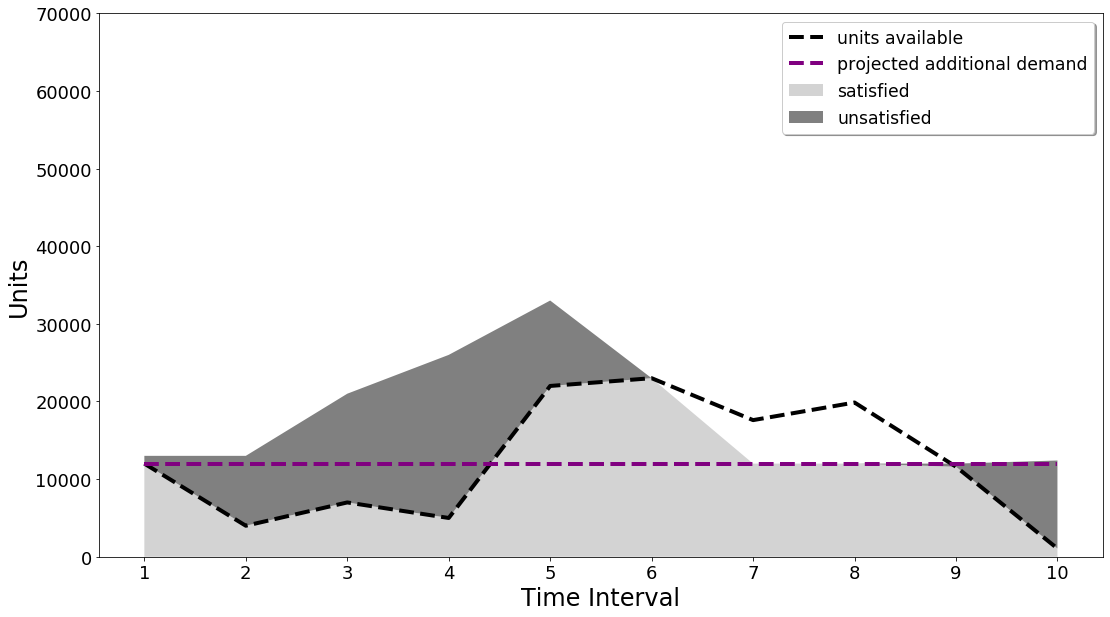

In [28]:
temp_all = unsatisfied_temp_df[['time_interval', 'units_unsatisfied']].\
merge(fulfilled_temp_df, how='inner', on='time_interval')

fig2, ax2 = plot.subplots(figsize=(18,10))

ax2.plot(available_temp_df['time_interval'], 
          available_temp_df['units_available'], 
          label='units available',
          color ="black",
         linewidth=4,
         linestyle='dashed') 

#ax2.plot(demand_df['time_interval'], 
#         temp_all['units_fulfilled']+temp_all['units_unsatisfied'] , 
#         label='total projected demand', #\n additional demand \nplus unfulfilled demand\nfrom the day before',
#         linewidth=4,
#         color = "purple",
#         linestyle='dashed')

ax2.plot(demand_df['time_interval'], 
         demand_df['demand_in_units'], 
         label='projected additional demand',
         linewidth=4,
         color = "purple",
         linestyle='dashed')

# Your x and y axis
x=range(1,T+1)
y=[temp_all['units_fulfilled'], temp_all['units_unsatisfied']]
 
# use a known color palette (see..)
pal = ["#D3D3D3", "#808080"]
plot.stackplot(x,y, labels=['satisfied', 'unsatisfied'], colors=pal)
plot.legend(loc='upper right')
plot.xticks(fontsize= 18)
plot.yticks(fontsize= 18)
ax2.xaxis.set_ticks(np.arange(1, T+1, 1))
ax2.yaxis.set_ticks(np.arange(0, 80000, 10000))

ax2.set_xlabel('Time Interval', fontsize=24)
ax2.set_ylabel('Units', fontsize=24)
#ax2.set_title('Available, Unsatisfied, and Satisfied Units of Masks (k=1) \n summed over all suppliers (i) at each Time Interval (t)\
#\n medium supplier risk, medium demand reliability', fontsize='xx-large')
#ax2.set_title('Available, Unsatisfied, and Satisfied Units of Masks during each Time Interval\
#\n Assuming Average (no variation) Supplier Capacity and Demand Projections, \n \
#and a Budget of \$80,000 over 10 Weeks', fontsize=24)
ax2.legend(loc='upper right', shadow=True, fontsize='xx-large')

In [29]:
temp_all['percent_unsatisfied'] = temp_all['units_unsatisfied']/(temp_all['units_fulfilled'] + temp_all['units_unsatisfied'])
temp_all['stacked'] = temp_all['units_fulfilled'] + temp_all['units_unsatisfied']

In [30]:
units = []
name = []
time_interval = []

In [31]:
for i in fulfilled_df.index:
    units.append(fulfilled_df['units_fulfilled'].iloc[i])
    time_interval.append(fulfilled_df['time_interval'].iloc[i])
    if (fulfilled_df['supplier'].iloc[i] == 1):
        name.append('High Capacity R US')
    elif (fulfilled_df['supplier'].iloc[i] == 2):
        name.append('Affordable PPE')
    elif (fulfilled_df['supplier'].iloc[i] == 3):
        name.append('Speedy Industries')
    else:
        name.append('High Quality Inc.')

        
for i in unsatisfied_df.index:
    units.append(unsatisfied_df['units_unsatisfied'].iloc[i])
    time_interval.append(unsatisfied_df['time_interval'].iloc[i])
    name.append('unsatisfied_demand')

In [32]:
temp = pd.DataFrame(list(zip(name, time_interval, units)), 
                    columns =['name', 'time_interval', 'units']) 

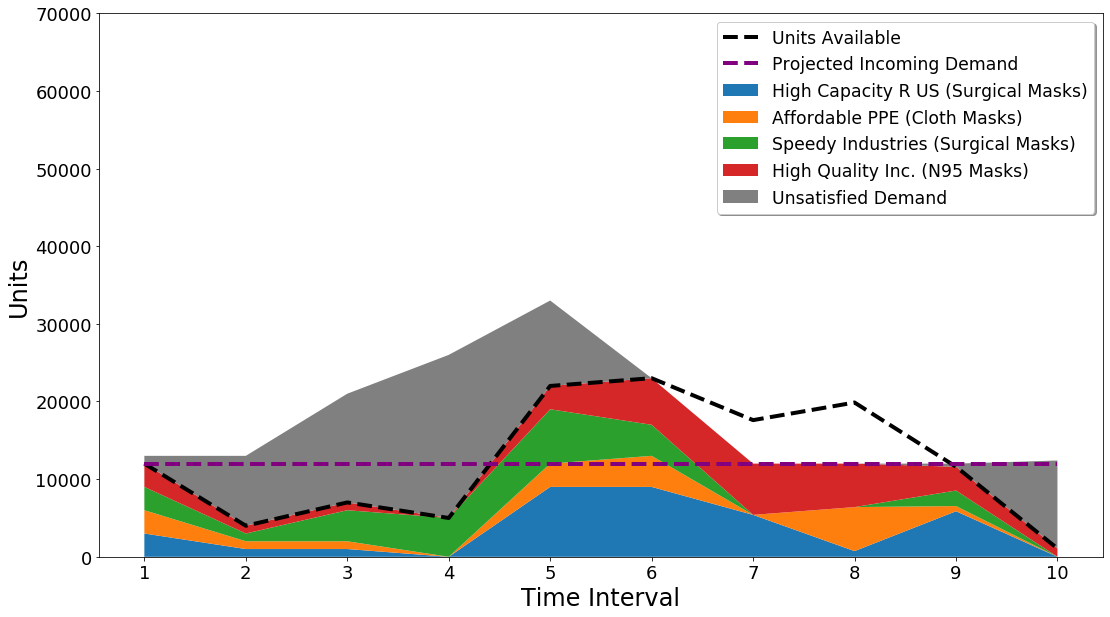

In [33]:
fig2, ax3 = plot.subplots(figsize=(18,10))

ax3.plot(available_temp_df['time_interval'], 
          available_temp_df['units_available'],  
          label='Units Available',
          color ="black",
         linewidth=4,
         linestyle='dashed') 

#ax3.plot(demand_df['time_interval'], 
#         temp_all['units_fulfilled']+temp_all['units_unsatisfied'] , 
#         label='Total Projected Demand', #\n additional demand \nplus unfulfilled demand\nfrom the day before',
#         linewidth=4,
#         color = "purple",
#         linestyle='dashed')

ax3.plot(demand_df['time_interval'], 
             demand_df['demand_in_units'], 
             label='Projected Incoming Demand',
             color ="purple",
         linewidth=4,
        linestyle='dashed')

# Your x and y axis
x=range(1,T+1)
y=[temp[temp['name'] == 'High Capacity R US']['units'], temp[temp['name'] == 'Affordable PPE']['units'],
  temp[temp['name'] == 'Speedy Industries']['units'], temp[temp['name'] == 'High Quality Inc.']['units'],
  temp[temp['name'] == 'unsatisfied_demand']['units']]
 
# use a known color palette (see..)
pal = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "808080"]
ax3.stackplot(x,y, labels=['High Capacity R US (Surgical Masks)', 'Affordable PPE (Cloth Masks)', 'Speedy Industries (Surgical Masks)', 
                            'High Quality Inc. (N95 Masks)', 'Unsatisfied Demand '], colors=pal)#, alpha=0.4)

plot.xticks(fontsize= 18)
plot.yticks(fontsize= 18)

ax3.xaxis.set_ticks(np.arange(1, T+1, 1))
ax3.yaxis.set_ticks(np.arange(0, 80000, 10000))


ax3.set_xlabel('Time Interval', fontsize=24)
ax3.set_ylabel('Units', fontsize=24)
#ax3.set_title('Available, Unsatisfied, and Satisfied Units of Masks from each Supplier during each Time Interval\
#\nAssuming Average (no variation) Supplier Capacity and Demand Projections, \n \
#and a Budget of \$80,000 over 10 Weeks', fontsize=24)
ax3.legend(loc='upper right', shadow=True, fontsize='xx-large')

In [34]:
I = 4

In [35]:
### ordering and recieving picture
pos_dict_all = {}
label_dict_all = {}
color_dict_all = {}
G_dict_all = {}
edge_labels_dict_all = {}

In [36]:
for i in range(1,I+1):
    #G=nx.Graph()
    G = nx.DiGraph()
    label_dict = {}
    color_map = []
    
    global ordered_df
    global recieved_df
    
    time_coordinates = range(1,T+1)
    ordered_amount_coordinates = np.array(ordered_df[(ordered_df['supplier'] == i)]['units_to_order'])
    recieved_amount_coordinates = np.array(recieved_df[(recieved_df['supplier'] == i)]['expected_units_recieved'])

    for t in range(T):
        ordered_amount = ordered_amount_coordinates[t]
        recieved_amount = recieved_amount_coordinates[t]

        if (ordered_amount > 0):
            name = 'ordered at ' + str(t+1) + ' from supplier ' + str(i)
            G.add_node(name, pos = (t+1,1))
            label_dict[name] = round(ordered_amount).astype(int)
            color_map.append('plum')

        if (recieved_amount > 0):
            name = 'recieved at ' + str(t+1)+ ' from supplier ' + str(i)
            G.add_node(name, pos = (t+1,2))
            label_dict[name] = round(recieved_amount).astype(int)
            color_map.append('palegreen')

    pos=nx.get_node_attributes(G,'pos')
    label_dict_all['supplier' + str(i)] = label_dict
    color_dict_all['supplier' + str(i)] = color_map
    pos_dict_all['supplier' + str(i)] = pos
    G_dict_all['supplier' + str(i)] = G
    
    ordered_df_filtered = ordered_df[(ordered_df['supplier'] == i) 
                                     & (ordered_df['units_to_order'] > 0)]
    
    for t_tilde in ordered_df_filtered['time_interval']:
        for t in range(T+1):
            if t_tilde < t:
                prob = f_k_i_tDiff_dict.get(tuple([1,i,t-t_tilde]))
                if (prob > 0):
                    temp = ordered_df_filtered[ordered_df_filtered['time_interval'] == t_tilde]
                    edge_start = 'ordered at ' + str(t_tilde) + ' from supplier ' + str(i)
                    edge_end = 'recieved at ' + str(t)+ ' from supplier ' + str(i)
                    amount = round((prob*temp['units_to_order'].values[0]),0).astype(int)
                    G.add_edge(edge_start, edge_end, label=amount)

    edge_labels_dict_all['supplier' + str(i)]  = nx.get_edge_attributes(G, 'label')

In [37]:
ordered_df_filtered = ordered_df[(ordered_df['supplier'] == 2) 
                                     & (ordered_df['units_to_order'] > 0)]

In [38]:
for k in edge_labels_dict_all.get('supplier' + str(i)).keys():
    temp1 = edge_labels_dict_all.get('supplier' + str(i)).get(k)
    temp2 = {k:temp1}
    print(temp2)

{('ordered at 1 from supplier 4', 'recieved at 4 from supplier 4'): 3000}
{('ordered at 1 from supplier 4', 'recieved at 5 from supplier 4'): 3000}
{('ordered at 1 from supplier 4', 'recieved at 6 from supplier 4'): 2000}
{('ordered at 1 from supplier 4', 'recieved at 7 from supplier 4'): 2000}
{('ordered at 2 from supplier 4', 'recieved at 5 from supplier 4'): 3000}
{('ordered at 2 from supplier 4', 'recieved at 6 from supplier 4'): 3000}
{('ordered at 2 from supplier 4', 'recieved at 7 from supplier 4'): 2000}
{('ordered at 2 from supplier 4', 'recieved at 8 from supplier 4'): 2000}
{('ordered at 3 from supplier 4', 'recieved at 6 from supplier 4'): 1600}
{('ordered at 3 from supplier 4', 'recieved at 7 from supplier 4'): 1600}
{('ordered at 3 from supplier 4', 'recieved at 8 from supplier 4'): 1067}
{('ordered at 3 from supplier 4', 'recieved at 9 from supplier 4'): 1067}


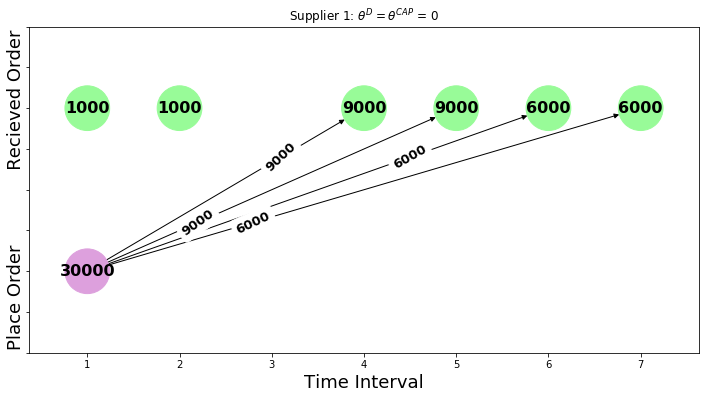

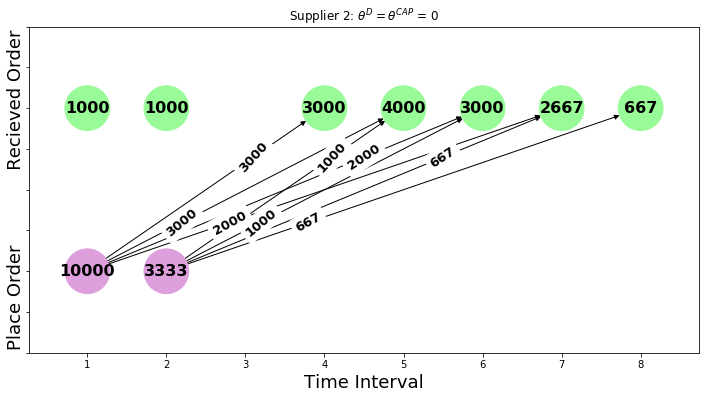

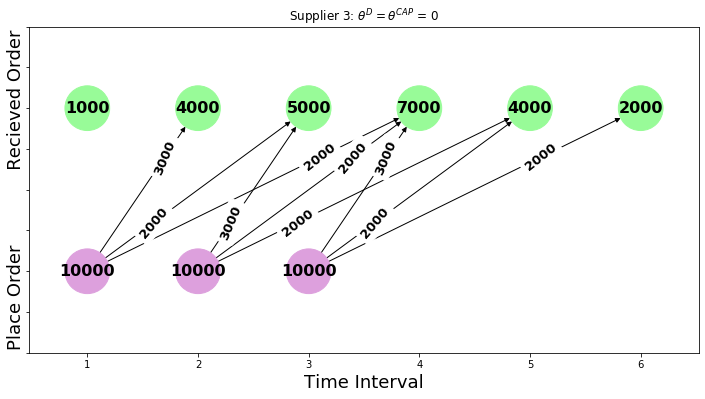

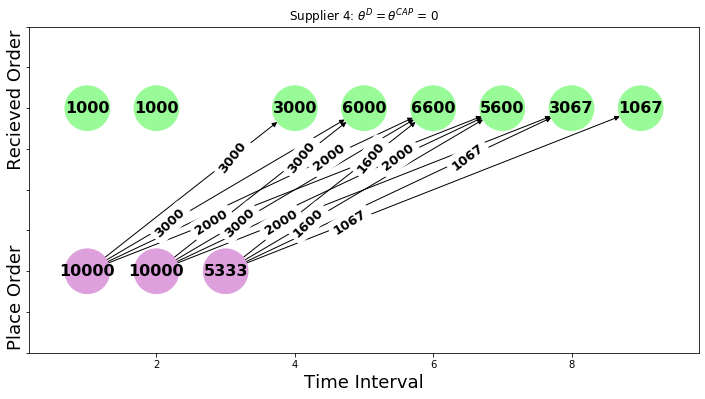

In [39]:
for i in range(1, I+1):
    fig, ax = plot.subplots(figsize=(12,6))
          
    nx.draw(G_dict_all.get('supplier' + str(i)),
            pos_dict_all.get('supplier' + str(i)), 
            labels=label_dict_all.get('supplier' + str(i)), 
            node_size=2000, font_size=16, with_labels = True, 
            node_color=color_dict_all.get('supplier' + str(i)), 
            ax = ax,
           font_weight = 'bold')
    
    label_pos_temp = .7
    
    for k in edge_labels_dict_all.get('supplier' + str(i)).keys():
        temp1 = edge_labels_dict_all.get('supplier' + str(i)).get(k)
        temp2 = {k:temp1}
        
        if(label_pos_temp == .7):
            label_pos_temp = .3
        else:
            label_pos_temp = .7
            
        nx.draw_networkx_edge_labels(G_dict_all.get('supplier' + str(i)), 
                                     pos_dict_all.get('supplier' + str(i)), 
                                     temp2,
                                     label_pos = label_pos_temp,
                                    arrows = True,
                                    font_size = 13,
                                    font_weight = 'bold')
        
        #nx.draw_networkx_edge_labels(G_dict_all.get('supplier' + str(i)), pos_dict_all.get('supplier' + str(i)), 
        #                             edge_labels_dict_all.get('supplier' + str(i)),
        #                            label_pos = pos_dict_all_labels)
    
    
    ax.set_xlabel('Time Interval',
                 fontsize = 18)
    ax.set_ylabel('Place Order             Recieved Order',
                 fontsize = 18)
    ax.set(ylim=(.5, 2.5))
    #ax.set_title('Time Interval Order is Placed and Recieved \n for Supplier '+ str(i)+' for Item 1',
    #            fontsize = 20)
    ax.set_title('Supplier ' + str(i) + ': ' + r'$\theta^D = \theta^{CAP}$ = 0')
    ax.tick_params(left=True, bottom=True, labelleft=False, labelbottom=True)
    limits=plot.axis('on')
    #plot.savefig('Item'+ i+ 'Supplier' + str(i)+'.jpg')